# Anomaly Detection to detect hacking attempts
## Yngve Mardal Moe

In [1]:
import requests
import io
import itertools

import numpy  as np
import pandas as pd
 
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import IsolationForest


## Let us prepare the dataset for analysis

In [2]:
csv_str = requests.get(url='http://yngvem.no/kdd1999_without_smurf_and_neptune.csv').content
data = pd.read_csv(io.StringIO(csv_str.decode('utf-8')), index_col=0)

In [3]:
data.head()

,duration: continuous,protocol_type: symbolic,service: symbolic,flag: symbolic,src_bytes: continuous,dst_bytes: continuous,land: symbolic,wrong_fragment: continuous,urgent: continuous,hot: continuous,...,dst_host_srv_count: continuous,dst_host_same_srv_rate: continuous,dst_host_diff_srv_rate: continuous,dst_host_same_src_port_rate: continuous,dst_host_srv_diff_host_rate: continuous,dst_host_serror_rate: continuous,dst_host_srv_serror_rate: continuous,dst_host_rerror_rate: continuous,dst_host_srv_rerror_rate: continuous,connection_type
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,234,1364,0,0,0,0,...,7,1.0,0.0,0.14,0.0,0.0,0.0,0.0,0.0,normal.


In [4]:
X, y = data.iloc[:, :-1], data.iloc[:, -1]
X = pd.get_dummies(X)

y = (y=='normal.').astype(int)    # Normal connections will be class 1, attacks will be class 0
y = 2*y - 1                    # Sklearn anomaly detection algorithms return -1 for outliers and 1 for inliers

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.4)

scaler = StandardScaler()
train_X.loc[:, :] = scaler.fit_transform(train_X)
test_X.loc[:, :] = scaler.transform(test_X)

/home/yngve/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### Let us check if indexes are the same on train_X and train_y

In [5]:
train_X.head()

,duration: continuous,src_bytes: continuous,dst_bytes: continuous,land: symbolic,wrong_fragment: continuous,urgent: continuous,hot: continuous,num_failed_logins: continuous,logged_in: symbolic,num_compromised: continuous,...,flag: symbolic_REJ,flag: symbolic_RSTO,flag: symbolic_RSTOS0,flag: symbolic_RSTR,flag: symbolic_S0,flag: symbolic_S1,flag: symbolic_S2,flag: symbolic_S3,flag: symbolic_SF,flag: symbolic_SH
86573,-0.146935,-0.002830,-0.067207,-0.005898,-0.032657,-0.004846,-0.058481,-0.008848,0.671727,-0.007105,...,-0.271253,-0.027359,-0.01216,-0.089318,-0.048245,-0.023321,-0.012856,-0.005898,0.297902,-0.032188
90051,-0.146935,-0.003357,-0.037905,-0.005898,-0.032657,-0.004846,-0.058481,-0.008848,0.671727,-0.007105,...,-0.271253,-0.027359,-0.01216,-0.089318,-0.048245,-0.023321,-0.012856,-0.005898,0.297902,-0.032188
7749,-0.146935,-0.003369,0.189197,-0.005898,-0.032657,-0.004846,-0.058481,-0.008848,0.671727,-0.007105,...,-0.271253,-0.027359,-0.01216,-0.089318,-0.048245,-0.023321,-0.012856,-0.005898,0.297902,-0.032188
1697895,-0.146298,-0.003216,-0.066343,-0.005898,-0.032657,-0.004846,-0.058481,-0.008848,0.671727,-0.007105,...,-0.271253,-0.027359,-0.01216,-0.089318,-0.048245,-0.023321,-0.012856,-0.005898,0.297902,-0.032188
1695232,-0.146935,-0.003433,-0.075144,-0.005898,-0.032657,-0.004846,-0.058481,-0.008848,-1.488701,-0.007105,...,3.686596,-0.027359,-0.01216,-0.089318,-0.048245,-0.023321,-0.012856,-0.005898,-3.356805,-0.032188


In [6]:
train_y.head()

86573      1
90051      1
7749       1
1697895    1
1695232    1
Name: connection_type, dtype: int64

## Time to do some anomaly detection

In [7]:
iforest = IsolationForest(contamination=0.05)
iforest.fit(train_X)
train_prediction = iforest.predict(train_X)
test_prediction = iforest.predict(test_X)

In [8]:
cm_train = metrics.confusion_matrix(train_y, train_prediction)
cm_test = metrics.confusion_matrix(test_y, test_prediction)

In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


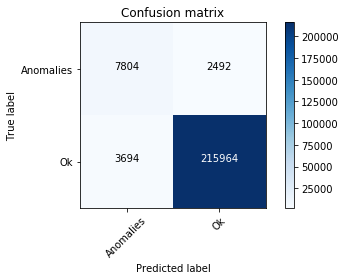

In [10]:
plot_confusion_matrix(cm_train, ['Anomalies', 'Ok'])
plt.show()

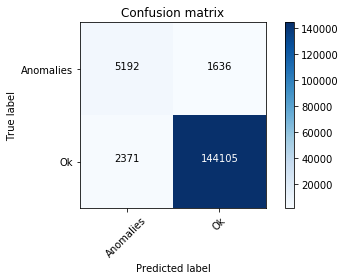

In [11]:
plot_confusion_matrix(cm_test, ['Anomalies', 'Ok'])
plt.show()